### Imports

In [3]:
import numpy as np
import torch
import pickle
import gymnasium as gym
import highway_env
import tensordict

### Creating Networks

In [4]:
import torch.nn as nn
from tensordict.nn.distributions import NormalParamExtractor

class AdvantageNet(nn.Sequential):
    def __init__(self, state_dim, d_hid, n_actions):
        super(AdvantageNet,self).__init__()

        # takes as input the dimension of our state space
        self.fc1 = nn.Linear(state_dim,d_hid)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(d_hid, d_hid)
        self.relu2 = nn.ReLU()
        # Output the expected cumulative return for each action
        self.fc3 = nn.Linear(d_hid, n_actions)
        self.npExtr = NormalParamExtractor()


class ValueNet(nn.Sequential):
    def __init__(self, state_dim, d_hid):
        super(ValueNet,self).__init__()

        # takes as input the dimension of our state space
        self.fc1 = nn.Linear(state_dim,d_hid)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(d_hid, d_hid)
        self.relu2 = nn.ReLU()
        # Output the expected cumulative return for each action
        self.fc3 = nn.Linear(d_hid, 1)

### Agent

In [5]:
class ReplayBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.done = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.done[:]

In [6]:
import random
from torch.distributions import Normal
import matplotlib.pyplot as plt

class PPO:
    def __init__(self, gamma):
        self.env = gym.make("racetrack-v0", render_mode="human")
        self.gamma = gamma
        obs,_ = self.env.reset()
        self.curr_obs = torch.tensor(obs.flatten())
        
        self.buffer = ReplayBuffer()

        self.eps = 0.2

        self.A = AdvantageNet(len(self.curr_obs), 256, 2)
        self.old_A = AdvantageNet(len(self.curr_obs), 256, 2)
        self.old_A.load_state_dict(self.A.state_dict())

        self.V = ValueNet(len(self.curr_obs), 256)
        self.old_V = ValueNet(len(self.curr_obs), 256)
        self.old_V.load_state_dict(self.V.state_dict())

        self.train_epochs = 5

        self.update_freq = 5

        self.n_episodes = 1000

        self.A_optimizer = torch.optim.Adam(self.A.parameters(), lr=0.005)
        self.V_optimizer = torch.optim.Adam(self.V.parameters(), lr=0.005)

        self.V_criterion = nn.MSELoss()

    def sample_action(self):
        
        mean, std = self.old_A(self.curr_obs)
        dist = Normal(mean, std)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.old_V(self.curr_obs)
        
        return action.detach(), action_logprob.detach(), state_val.detach()
    
    def evaluate_sa(self, state, action):
        action_mean, action_std = self.A(state)
        dist = Normal(action_mean, action_std)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_val = self.V(state)

        return action_logprobs, state_val, dist_entropy

    def advantage_Monte_Carlo(self):
        rewards = []
        disc_rew_list = []
        discounted_reward = 0
        for reward, done in zip(reversed(self.buffer.rewards), reversed(self.buffer.done)):
            if done and discounted_reward != 0:
                disc_rew_list.append(discounted_reward)
                discounted_reward = 0
            discounted_reward = reward + self.gamma*discounted_reward
            rewards.insert(0,discounted_reward)

        rewards = torch.tensor(rewards).reshape(-1,1)

        value_estimations = torch.tensor(self.buffer.state_values).detach().reshape(-1,1)

        advantage = rewards.detach() - value_estimations.detach()
        advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

        return advantage, rewards.float().detach(), disc_rew_list


    def compute_trajectory(self):
        self.curr_obs, _ = self.env.reset()
        self.curr_obs = torch.tensor(self.curr_obs).flatten()

        done = 0
        while not done:

            action, action_log_prob, state_val = self.sample_action()

            self.buffer.states.append(self.curr_obs.detach())
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_log_prob)
            self.buffer.state_values.append(state_val)

            self.curr_obs, reward, terminated, truncated, _ = self.env.step(action.detach().numpy())
            
            done = terminated or truncated or not np.sum(self.curr_obs[1,:,:])
            
            self.curr_obs = torch.tensor(self.curr_obs).flatten()
            
            self.buffer.rewards.append(reward)
            self.buffer.done.append(done)

    def clip_update(self, logprob_ratio):
        return torch.clip(logprob_ratio, 1-self.eps, 1+self.eps)

    def update_network(self):
        advantages, prev_state_values, disc_rew_list = self.advantage_Monte_Carlo()
        
        prev_states = torch.stack(self.buffer.states).detach()
        prev_actions = torch.stack(self.buffer.actions).detach()
        prev_logprobs = torch.stack(self.buffer.logprobs).detach()
        
        loss_A_items = []
        loss_V_items = []
        for _ in range(self.train_epochs):
            logprobs, state_values, dist_entropy = self.evaluate_sa(prev_states, prev_actions)

            logprobs_ratio = torch.exp(logprobs - prev_logprobs.detach())
            A_loss_first_term = logprobs_ratio * advantages
            A_loss_second_term = self.clip_update(logprobs_ratio) * advantages

            loss_A = -torch.min(A_loss_first_term, A_loss_second_term)

            loss_V = self.V_criterion(state_values, prev_state_values)

            self.A_optimizer.zero_grad()
            loss_A.mean().backward()
            self.A_optimizer.step()

            self.V_optimizer.zero_grad()
            loss_V.mean().backward()
            self.V_optimizer.step()

            loss_A_items.append(loss_A.mean().item())
            loss_V_items.append(loss_V.mean().item())

        self.old_A.load_state_dict(self.A.state_dict())
        self.old_V.load_state_dict(self.V.state_dict())

        self.buffer.clear()
        return np.mean(loss_A_items), np.mean(loss_V_items), np.mean(disc_rew_list)


    def train(self):
        lA_list = []
        lV_list = []
        reward_list = []
        for k in range(self.n_episodes):
            self.compute_trajectory()

            if k % self.update_freq == 0:
                lA, lV, disc_rew = self.update_network()
                lA_list.append(lA)
                lV_list.append(lV)
                reward_list.append(disc_rew)

                # First figure for lA_list
                plt.figure()
                plt.plot(lA_list, label='Actor loss')
                plt.title('Actor loss Over Time')
                plt.xlabel('Number of Updates')
                plt.ylabel('loss Value')
                plt.legend()
                plt.grid(True)

                # Second figure for lV_list
                plt.figure()
                plt.plot(lV_list, label='Value', color='orange')
                plt.title('Value Function Over Time')
                plt.xlabel('Number of Updates')
                plt.ylabel('Value Estimate')
                plt.legend()
                plt.grid(True)

                # Third figure for reward
                plt.figure()
                plt.plot(reward_list, label='Value', color='orange')
                plt.title('Disounted Reward Over Time')
                plt.xlabel('Number of Updates')
                plt.ylabel('Discounted Rewards on the trajectory')
                plt.legend()
                plt.grid(True)

                # Show both figures
                plt.show()

d:\Etudes\MASTER\CentraleSupelec\Cours\RL\proj\RL_projet\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Etudes\MASTER\CentraleSupelec\Cours\RL\proj\RL_projet\venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


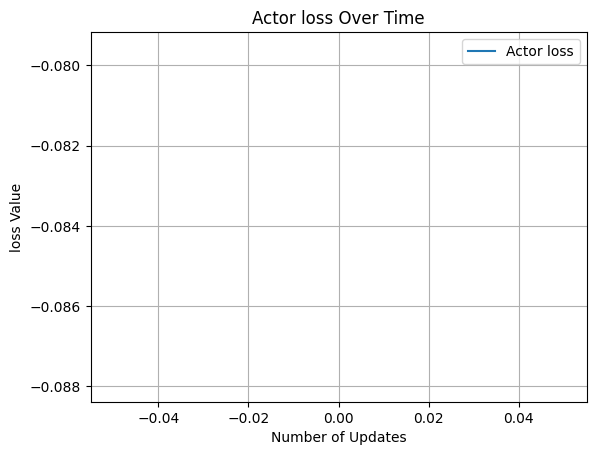

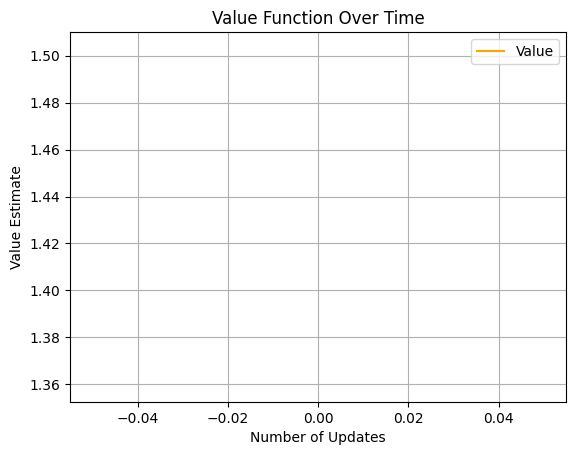

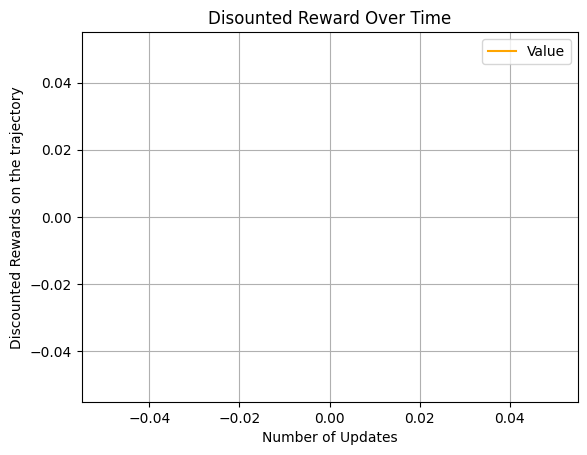

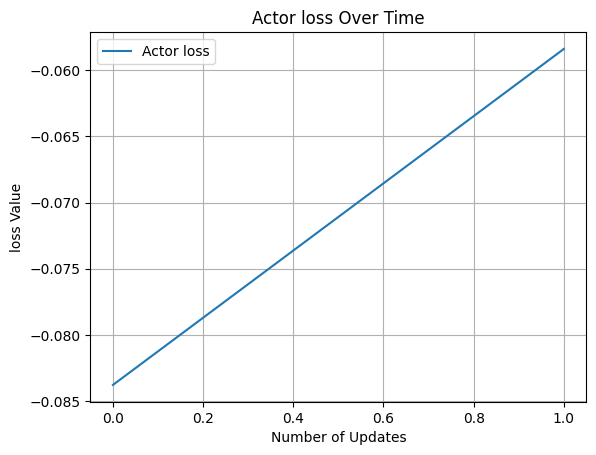

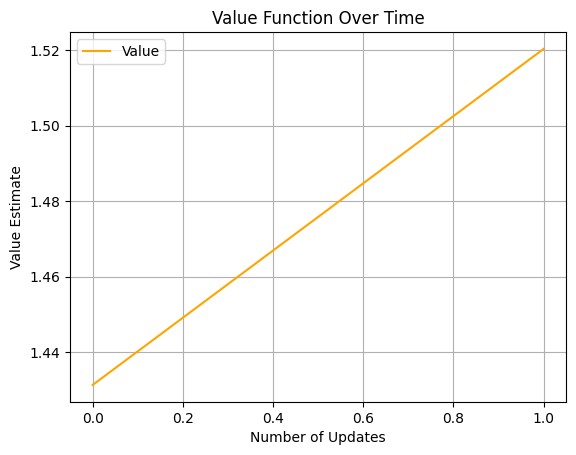

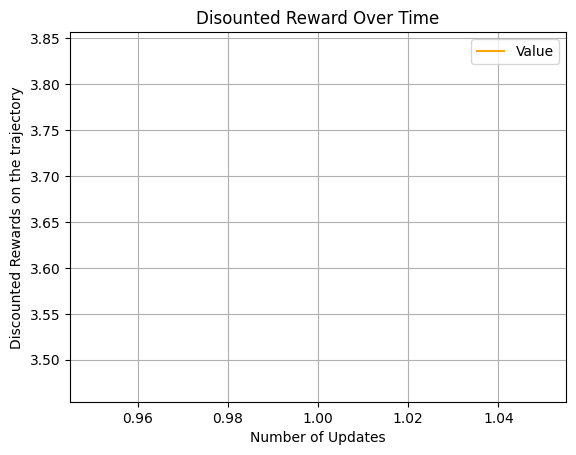

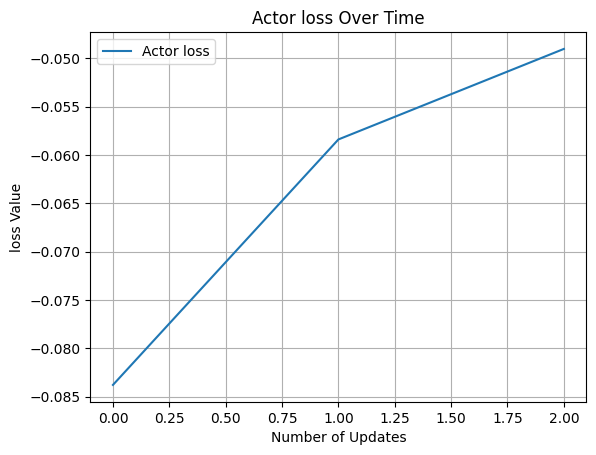

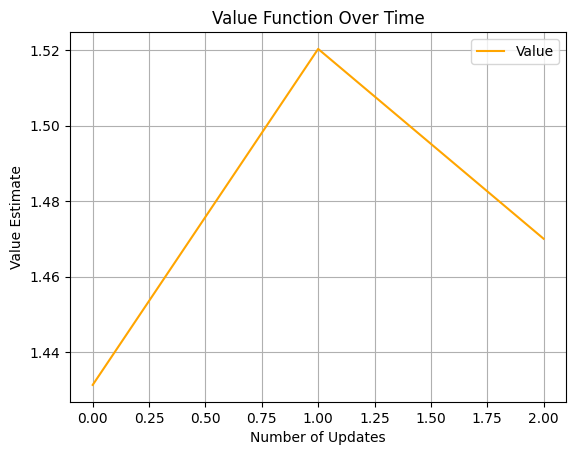

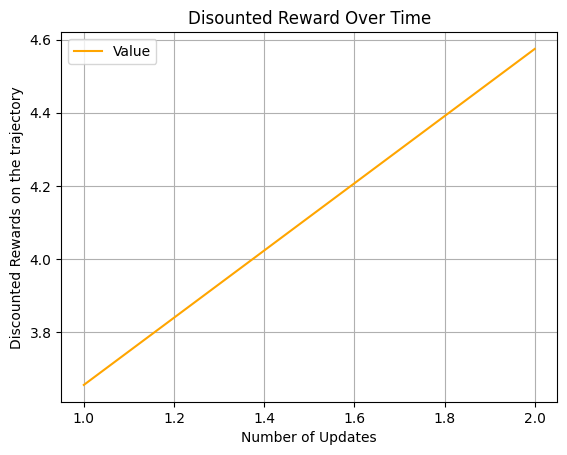

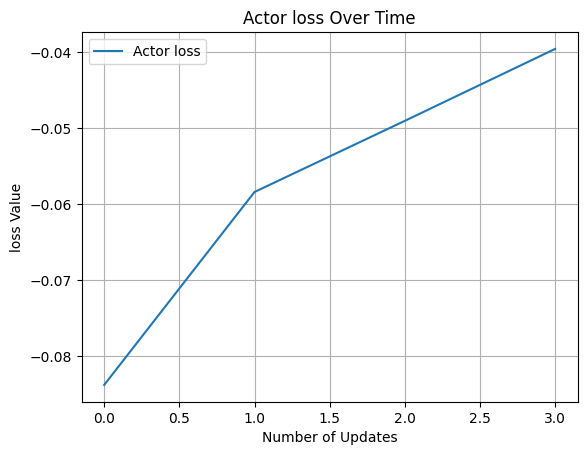

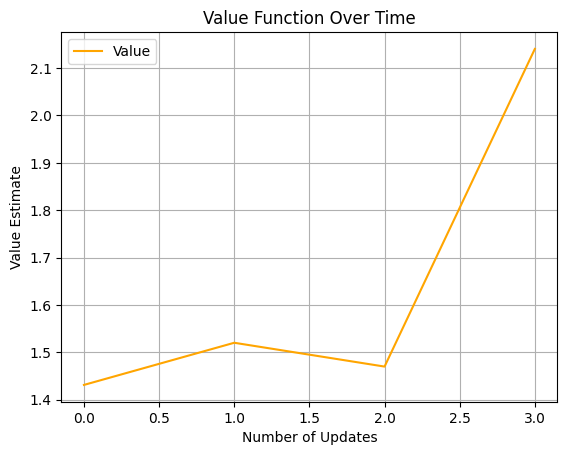

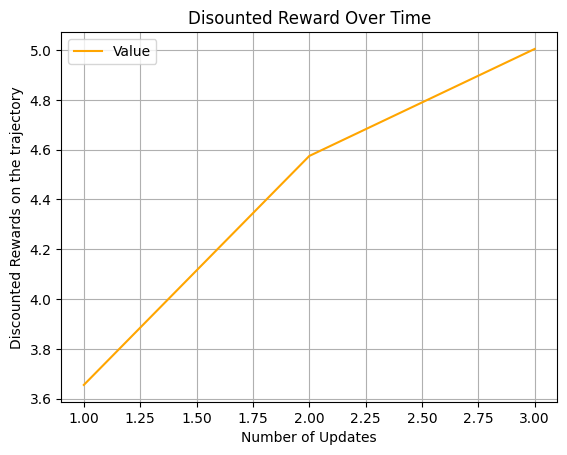

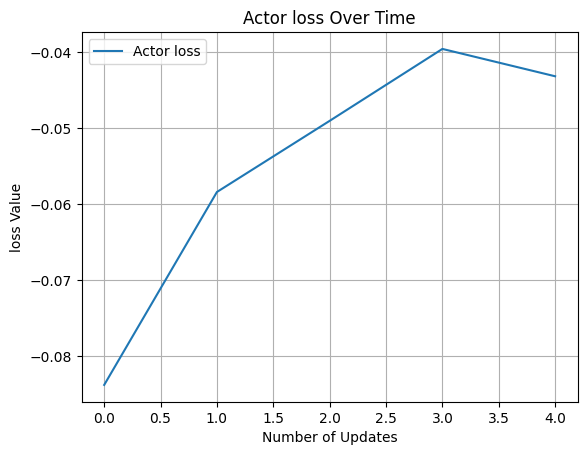

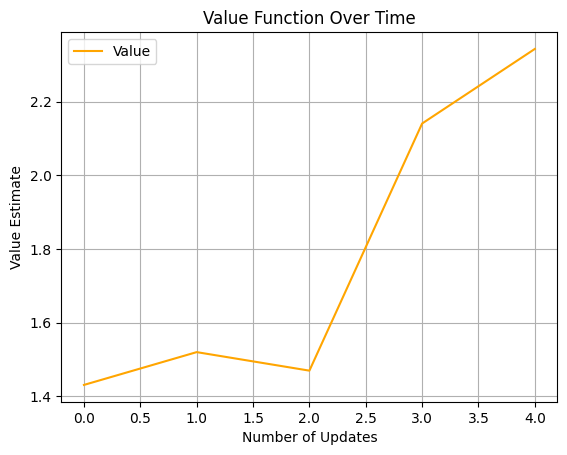

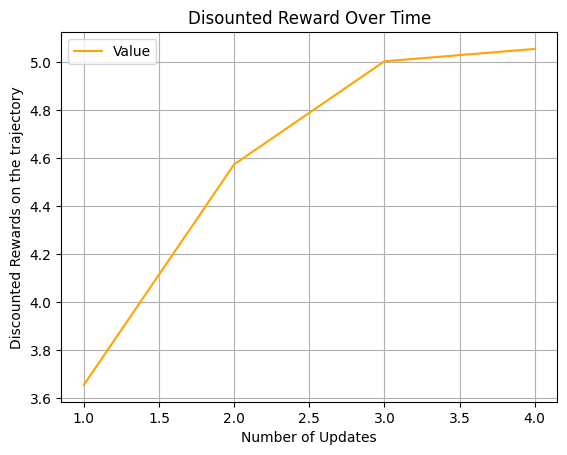

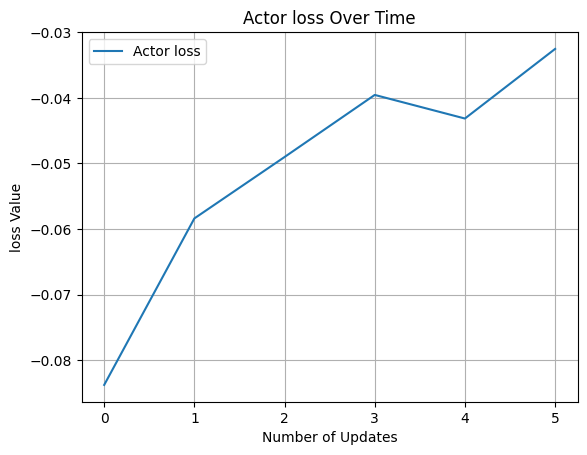

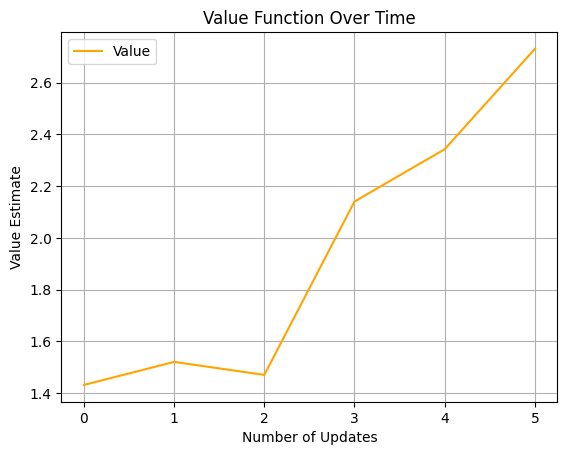

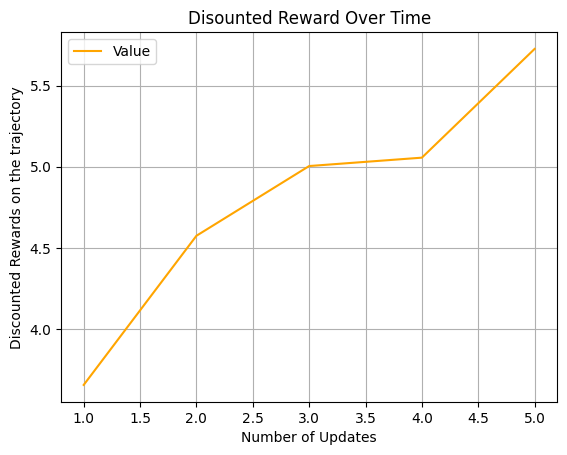

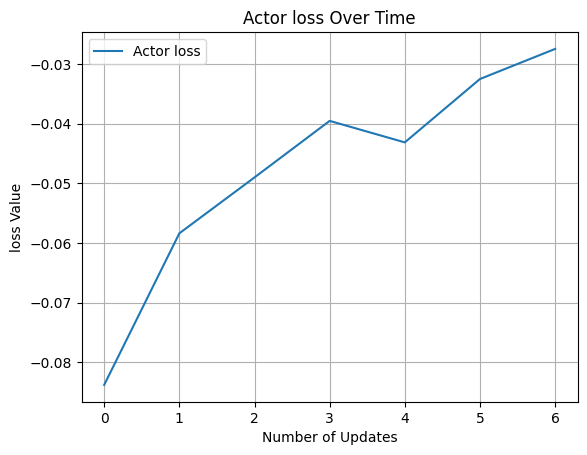

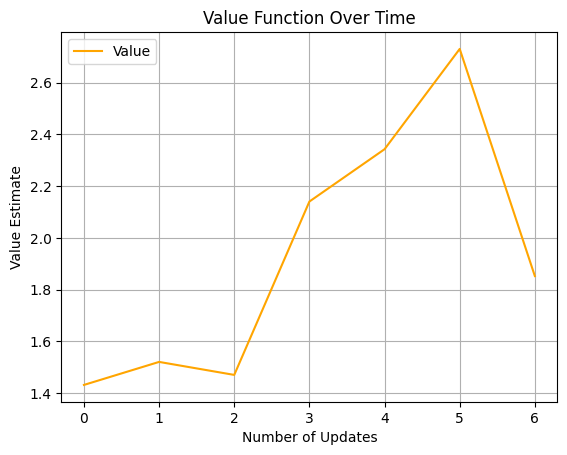

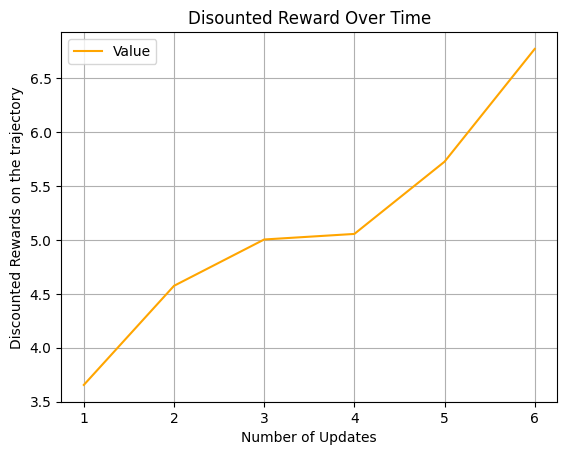

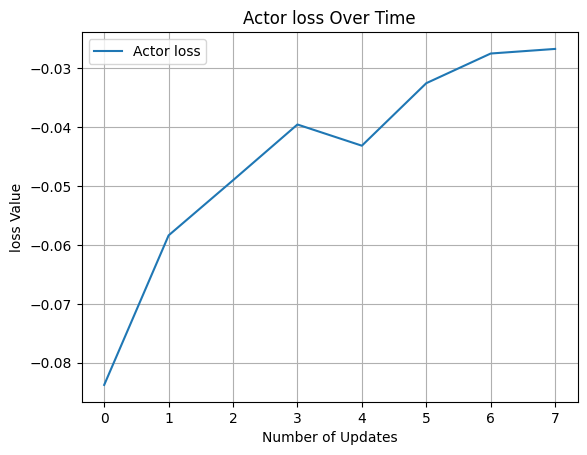

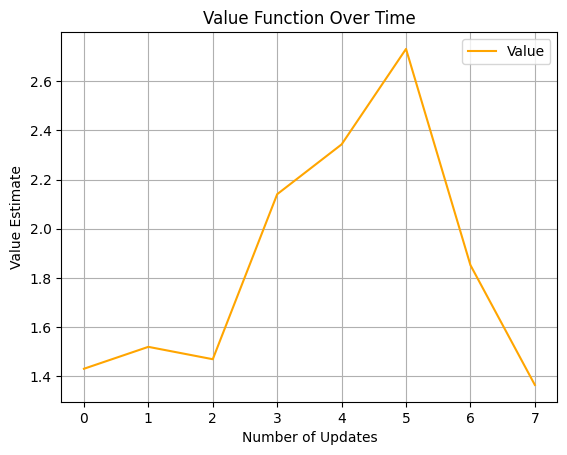

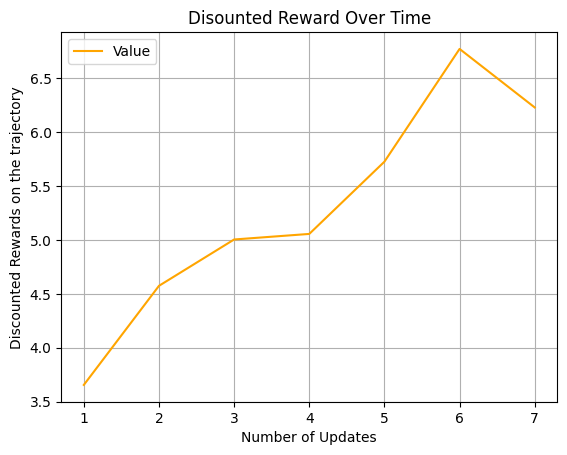

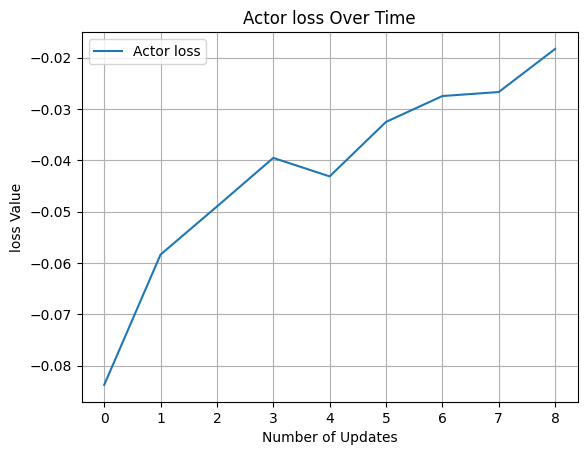

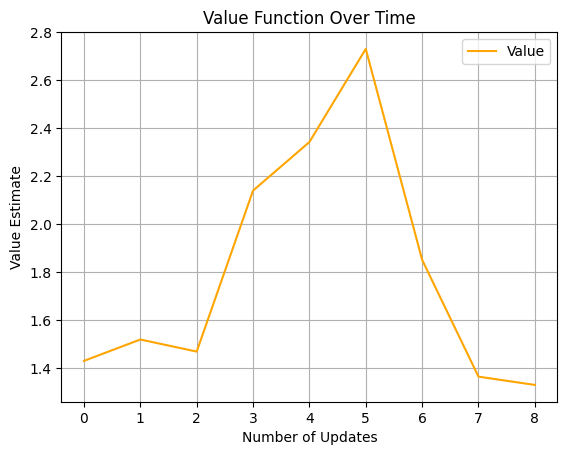

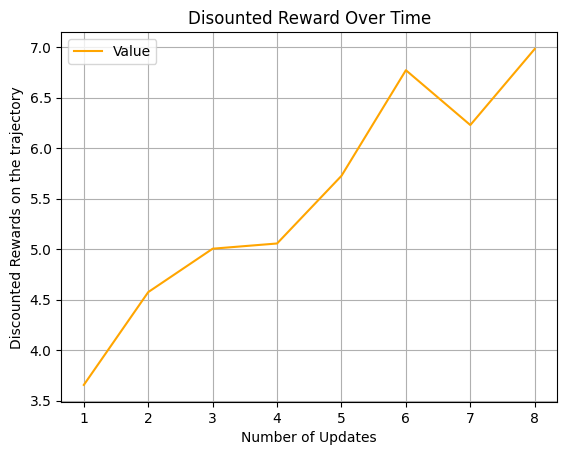

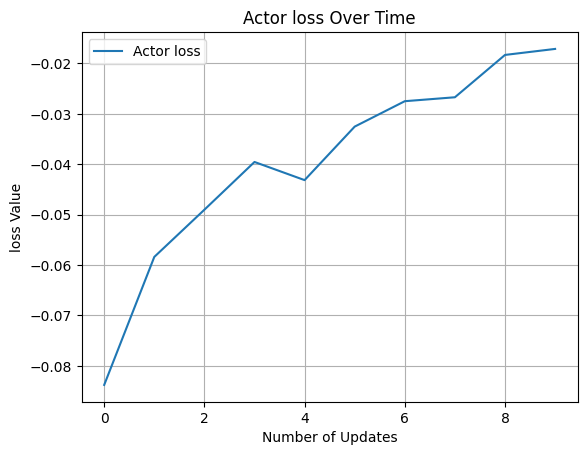

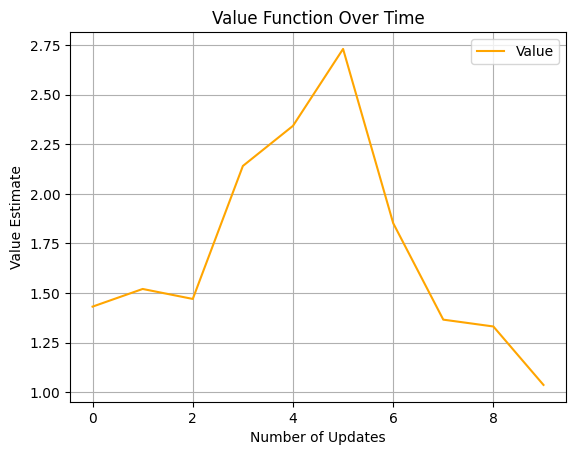

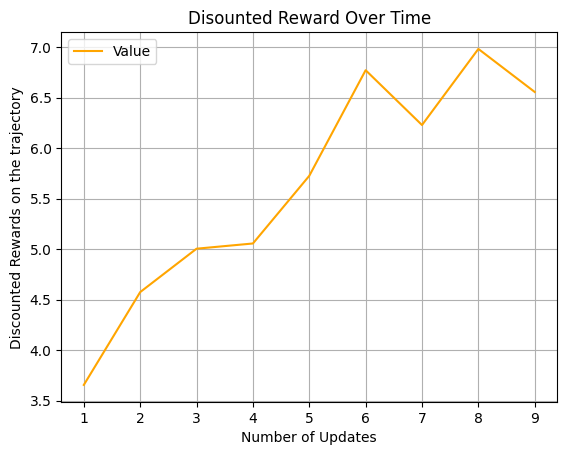

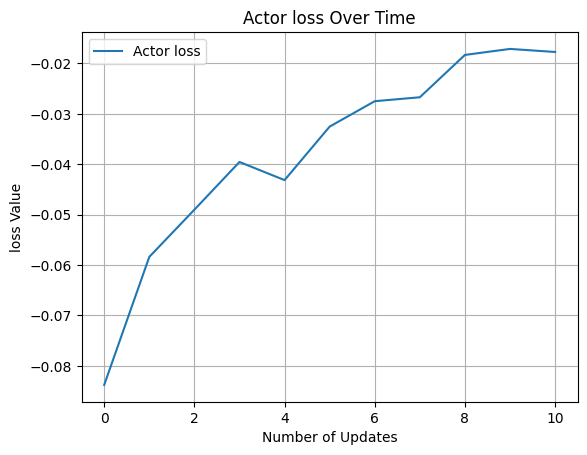

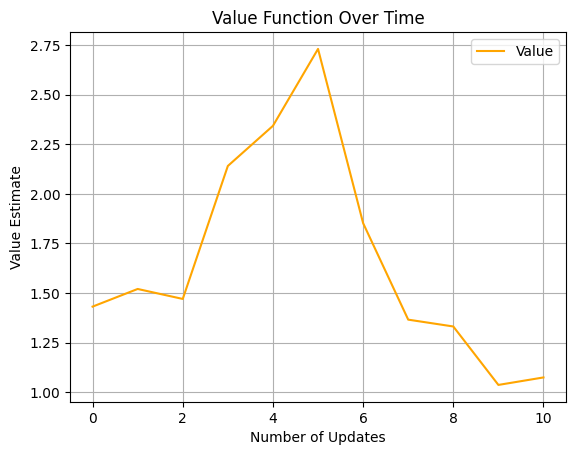

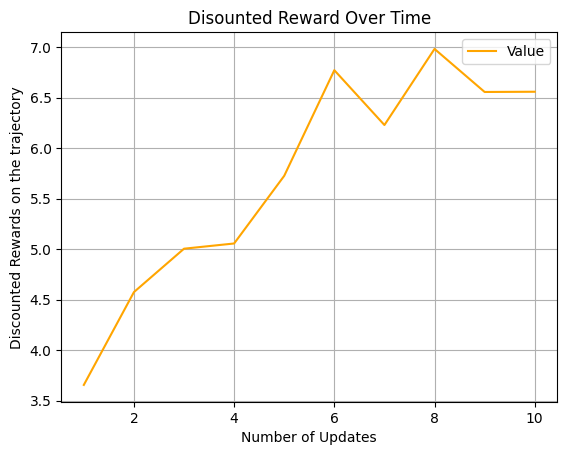

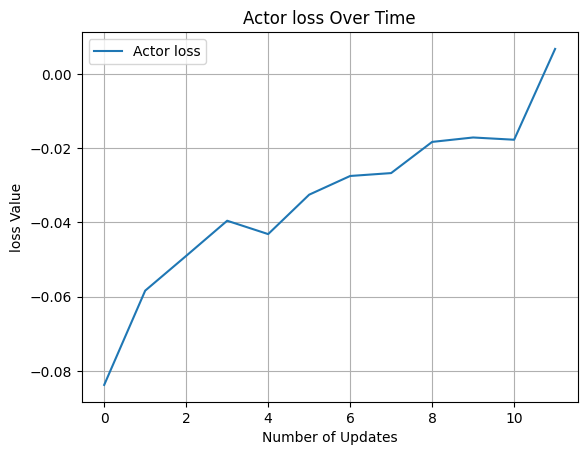

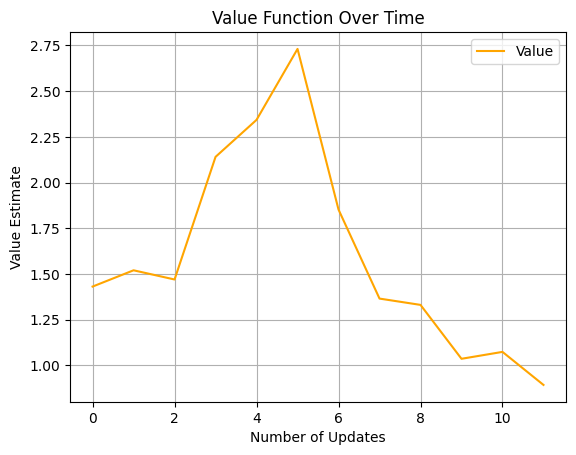

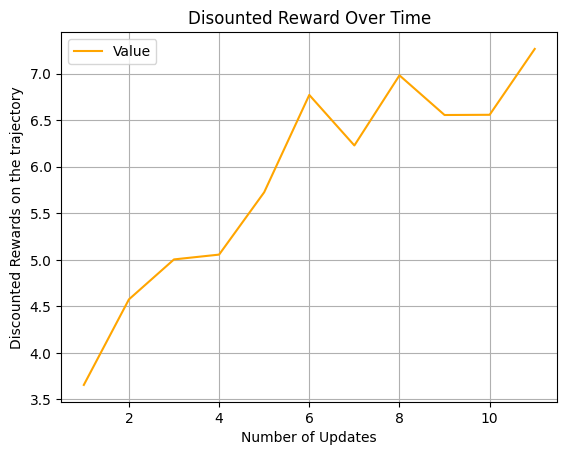

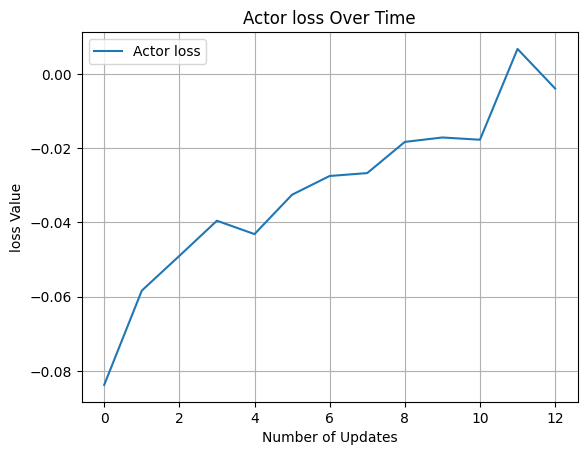

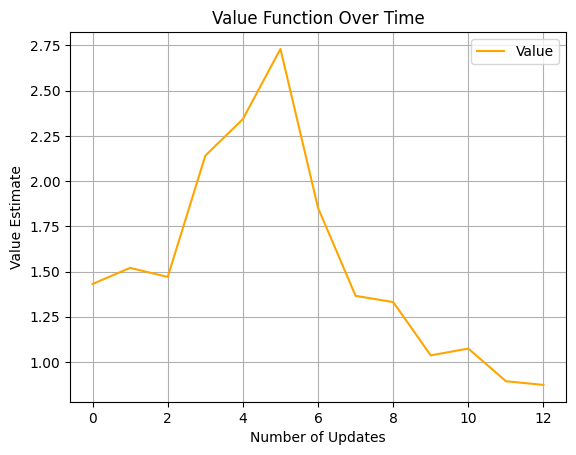

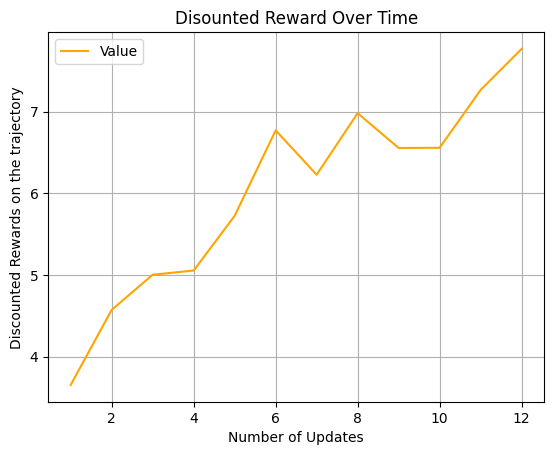

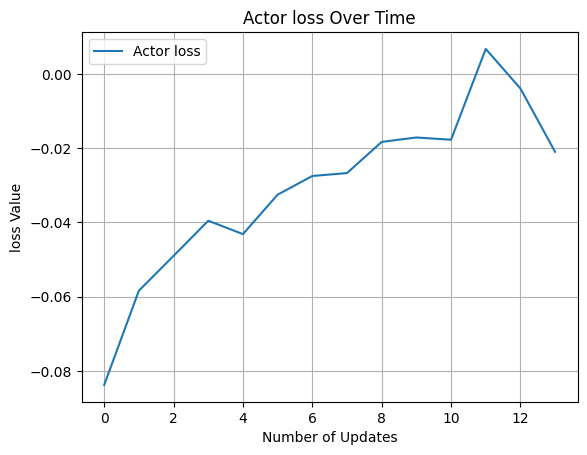

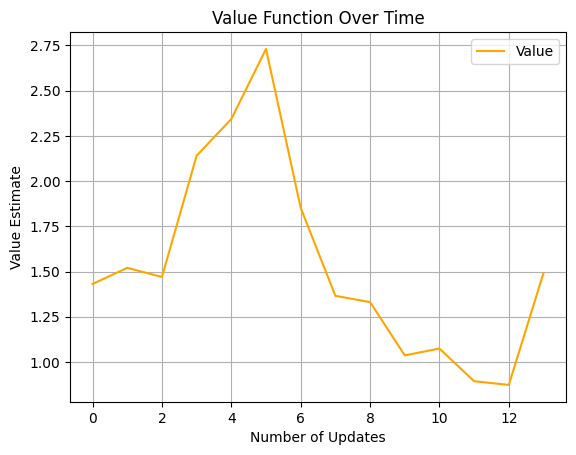

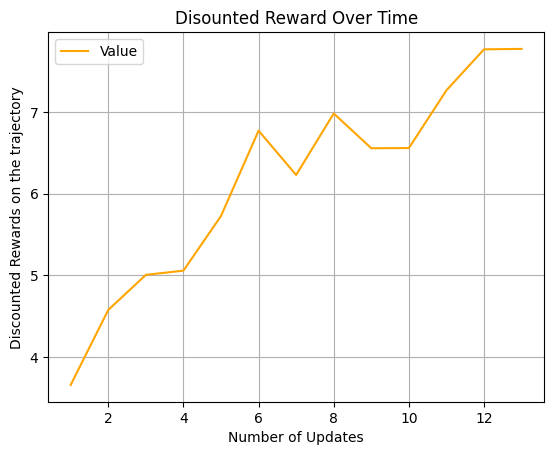

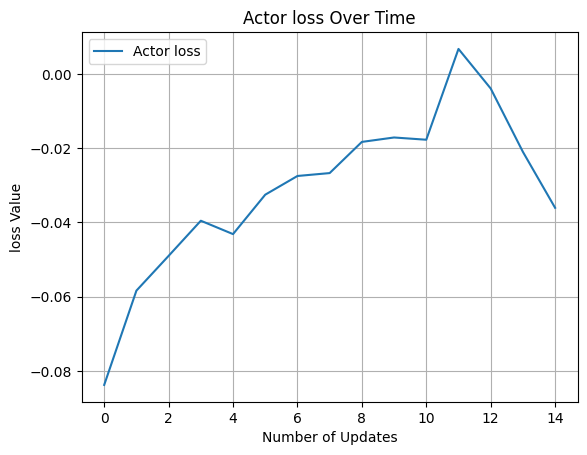

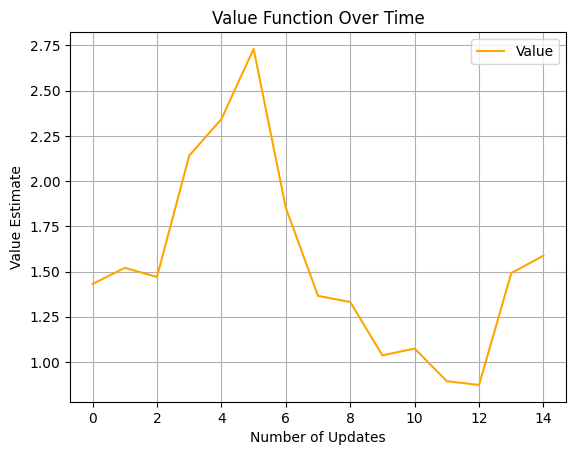

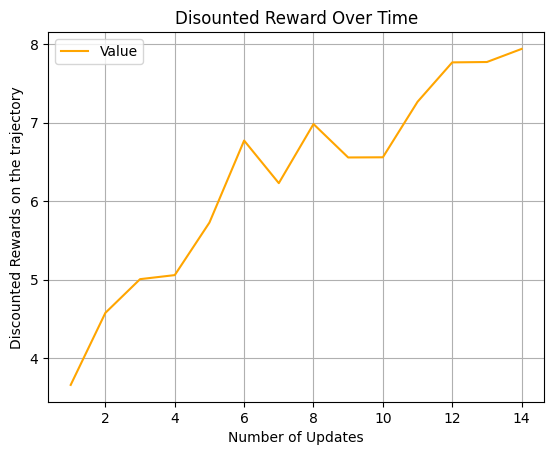

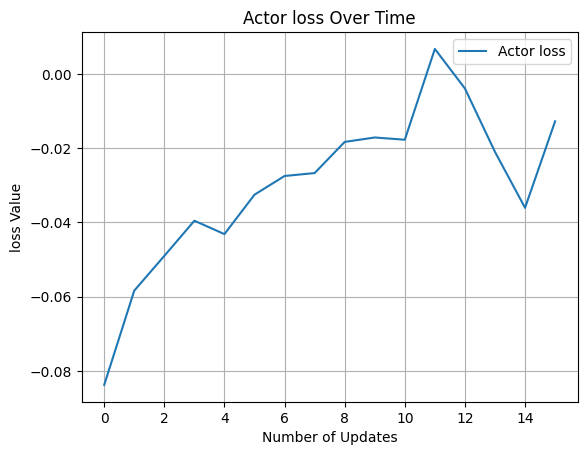

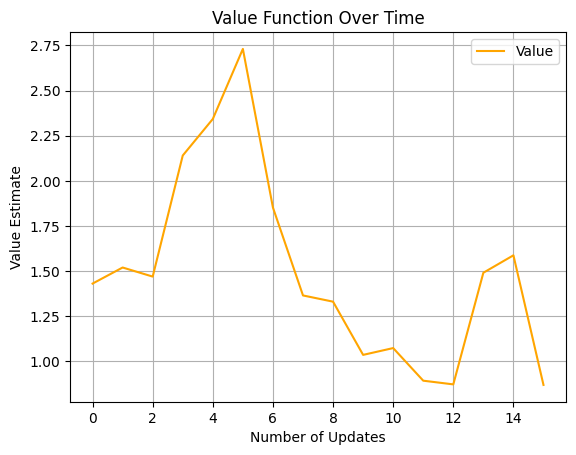

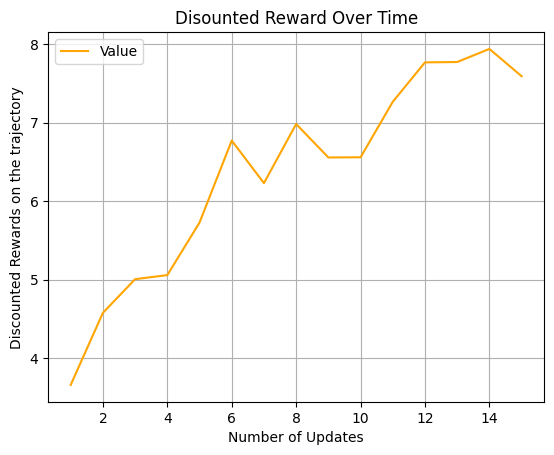

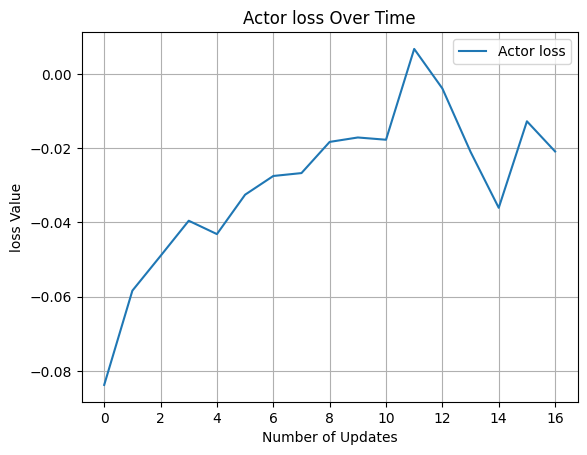

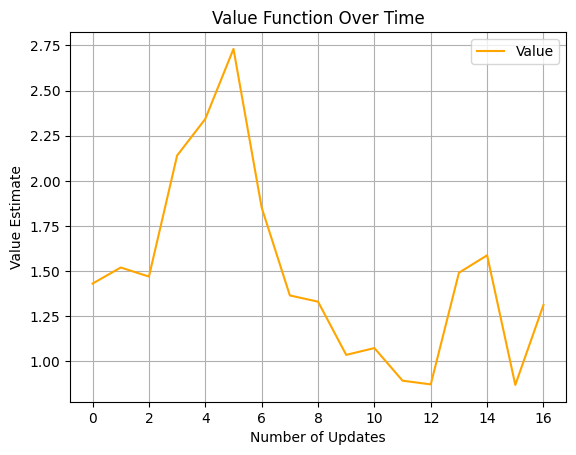

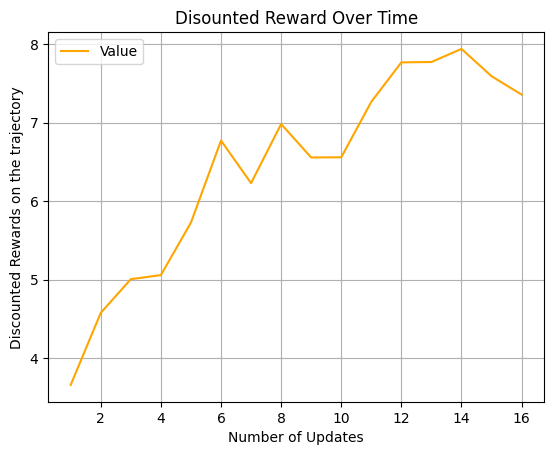

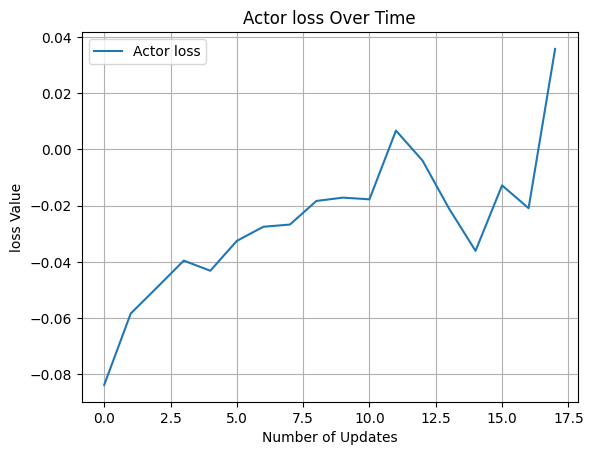

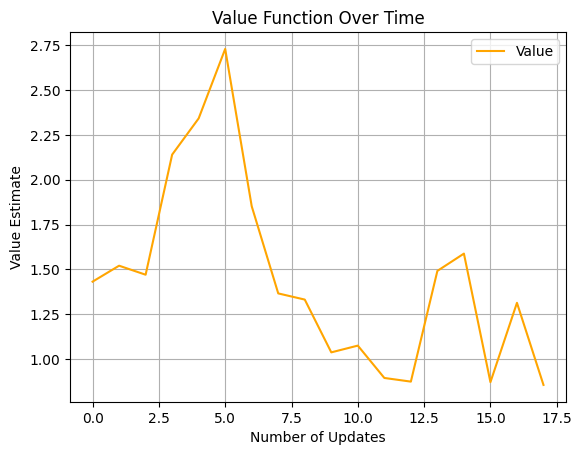

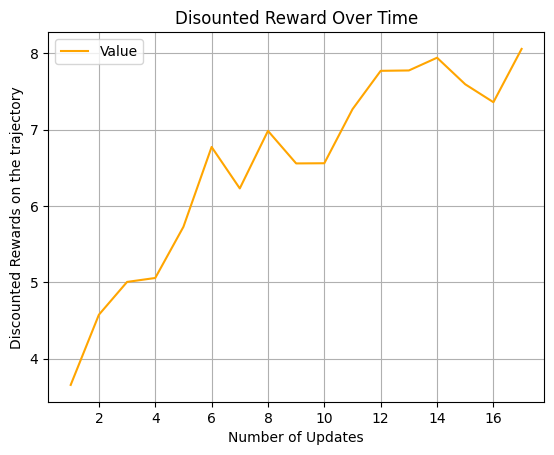

KeyboardInterrupt: 

: 

In [ ]:
ppo = PPO(0.9)
ppo.train()